In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import argparse
import json
import pandas as pd
import keras
import random

import tensorflow as tf
assert(tf.__version__ == "1.15.2")
assert(keras.__version__ == "2.2.4")

# Define working directory
ROOT_DIR = os.path.abspath("../")
sys.path.append(ROOT_DIR)
ROOT_DIR = os.path.abspath("../../")
sys.path.append(ROOT_DIR)

from mrcnn.model import log
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from utils.dataset import BloodCellDatasetFromDataFrame
from utils.configs import BloodCellConfig_Inference

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "maskrcnn-master","logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "maskrcnn-master", "mask_rcnn_coco.h5")

# Directory of images to run detection on
IMAGE_DIR_A = os.path.join(ROOT_DIR, "BCCD_Dataset/BCCD")

# Directory of images to run detection on
IMAGE_DIR_B = os.path.join(ROOT_DIR, "segmentation_WBC")

if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

IMAGE_COLLECTION_PATH = r'../blood_cell_dataset.pkl'


Using TensorFlow backend.


In [3]:
if not os.path.exists(IMAGE_COLLECTION_PATH):
    raise Exception(f"IC_PATH @ {IMAGE_COLLECTION_PATH} not found.")
else:
    dataset = pd.read_pickle(IMAGE_COLLECTION_PATH)
    train_samples_A = dataset[(dataset["role"] == "train")&(dataset["origin"] == "A")]
    train_samples_B = dataset[(dataset["role"] == "train")&(dataset["origin"] == "B")]
    val_samples = dataset[dataset["role"] == "val"]

print(f"Number of samples in training set A: {len(train_samples_A)}")
print(f"Number of samples in training set B: {len(train_samples_B)}")
print(f"Number of samples in valid set: {len(val_samples)}")

Number of samples in training set A: 295
Number of samples in training set B: 100
Number of samples in valid set: 69


In [4]:
dataset_train_A = BloodCellDatasetFromDataFrame(train_samples_A, directory_path_A = IMAGE_DIR_A)
dataset_train_A.load_kernel()

dataset_train_B = BloodCellDatasetFromDataFrame(train_samples_B, directory_path_B = IMAGE_DIR_B)
dataset_train_B.load_kernel()

dataset_val = BloodCellDatasetFromDataFrame(val_samples, directory_path_A = IMAGE_DIR_A)
dataset_val.load_kernel()

In [20]:
config = BloodCellConfig_Inference()
config.IMAGE_RESIZE_MODE = "crop"
config.IMAGE_SHAPE = [640,640,3]

## 1. Train set A (from kaggle, bbox only, no masks)

original_image           shape: (1024, 1024, 3)       min:   71.00000  max:  239.00000  uint8
image_meta               shape: (21,)                 min:    0.00000  max: 1024.00000  float64
gt_class_id              shape: (9,)                  min:    1.00000  max:    7.00000  int32
gt_bbox                  shape: (9, 4)                min:    0.00000  max: 1024.00000  int32
gt_mask                  shape: (1024, 1024, 9)       min:    0.00000  max:  127.00000  uint8


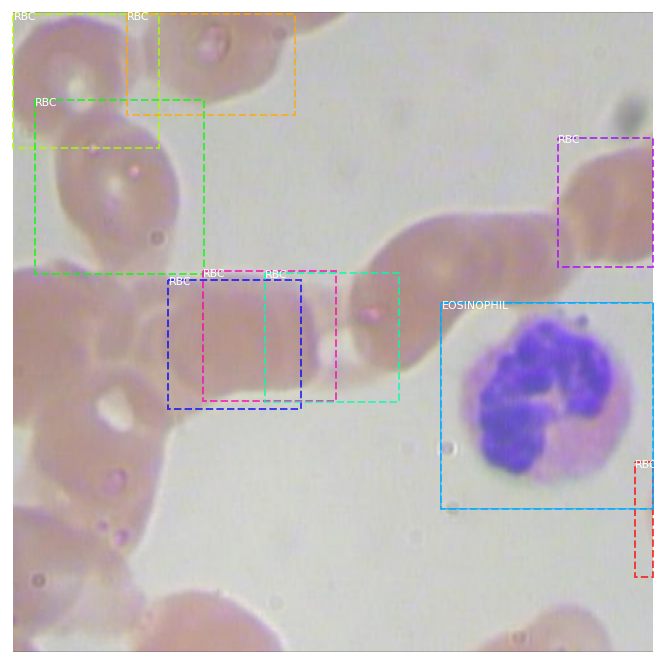

In [21]:
image_id = random.choice(dataset_train_A.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_train_A, config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train_A.class_names_preset, figsize=(12, 12))

## 2. Train set B (from github, masks)

original_image           shape: (1024, 1024, 3)       min:    2.00000  max:  255.00000  uint8
image_meta               shape: (21,)                 min:    0.00000  max: 1024.00000  float64
gt_class_id              shape: (1,)                  min:    5.00000  max:    5.00000  int32
gt_bbox                  shape: (1, 4)                min:  221.00000  max:  885.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:  255.00000  uint8


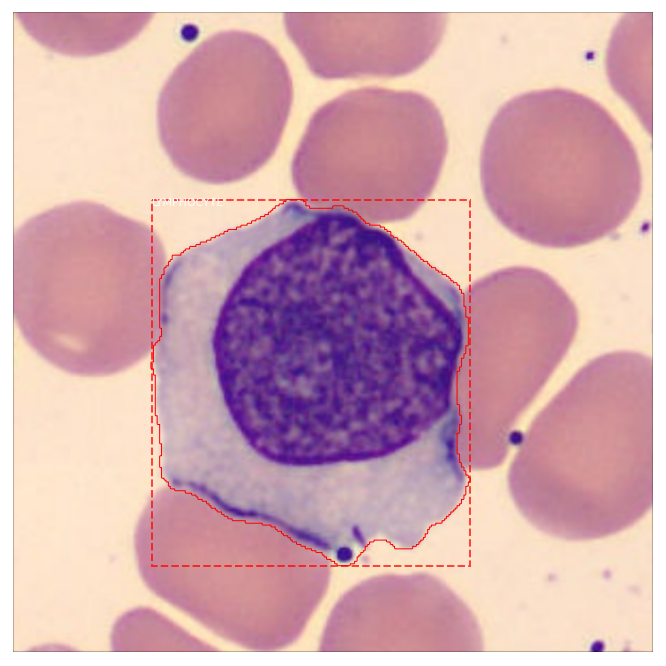

In [22]:
image_id = random.choice(dataset_train_B.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_train_B, config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train_B.class_names_preset, figsize=(12, 12))

## 3. Val set

original_image           shape: (1024, 1024, 3)       min:   80.00000  max:  250.00000  uint8
image_meta               shape: (21,)                 min:    0.00000  max: 1024.00000  float64
gt_class_id              shape: (11,)                 min:    1.00000  max:    4.00000  int32
gt_bbox                  shape: (11, 4)               min:    0.00000  max: 1024.00000  int32
gt_mask                  shape: (1024, 1024, 11)      min:    0.00000  max:  127.00000  uint8


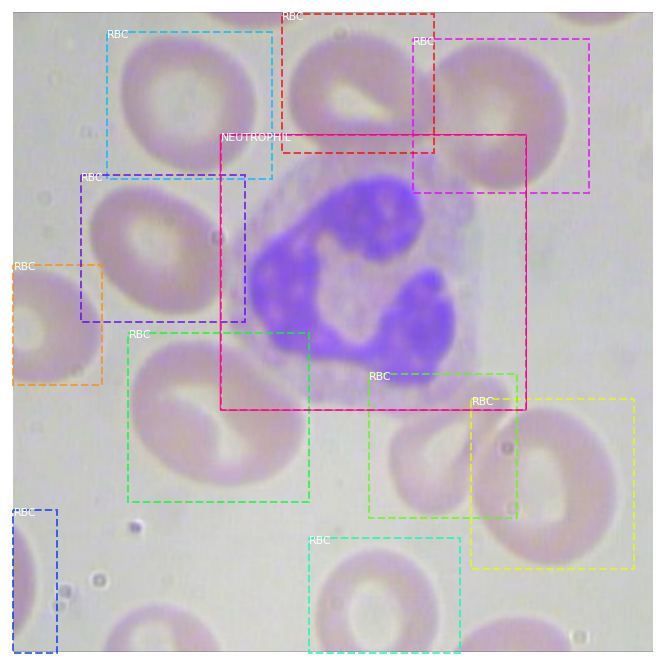

In [23]:
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_val.class_names_preset, figsize=(12, 12))

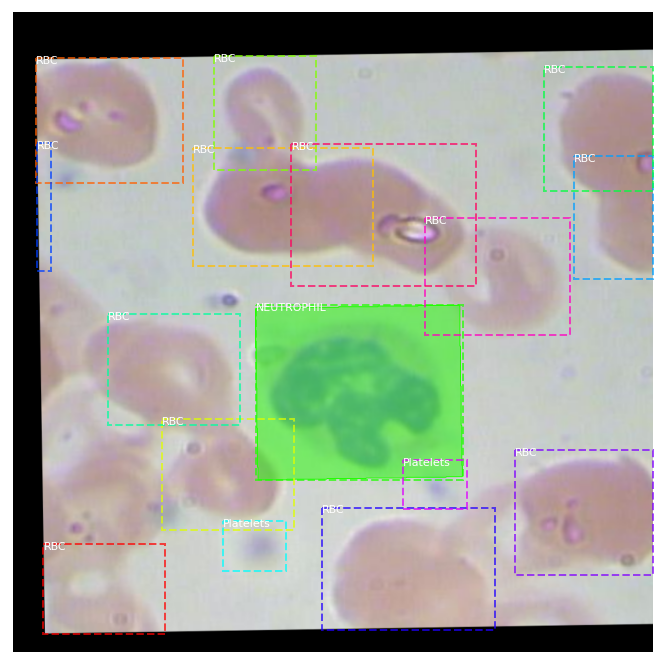

In [24]:
import imgaug as ia
import imgaug.augmenters as iaa

image_id = random.choice(dataset_val.image_ids)

sometimes = lambda aug: iaa.Sometimes(1, aug)
seq = iaa.Sequential(
    [
        # apply the following augmenters to most images
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        iaa.Flipud(0.2), # vertically flip 20% of all images
        sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            rotate=(-10, 10), # rotate by -45 to +45 degrees
            order=[1], # use nearest neighbour or bilinear interpolation (fast)
            cval=0, # if mode is constant, use a cval between 0 and 255
            mode=["constant"] # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        ))
    ])

original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, config, 
                           image_id, 
                           augmentation=iaa.Sometimes(1.0, seq), 
                           use_mini_mask=False)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_val.class_names_preset, figsize=(12, 12))